<h1 style="
  font-size: 55px;
  text-align: center;
  font-family: 'Poppins', sans-serif;
  text-shadow: 2px 2px 5px rgba(63, 155, 77, 0.84);
  letter-spacing: 2px;
">
  <b>📊 Merged Dataset</b>
</h1>
<hr style="width: 60%; border: 2px solid #21996fd1; border-radius: 5px;">


## <span style="color:#21996fd1;">**6- Model Training & Evaluation**
,---

In [94]:
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, classification_report

from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import TomekLinks

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [95]:
df=pd.read_csv("encoded_data.csv")

In [96]:
y = df["TARGET"]
X = df.drop(columns=["TARGET"])
# Use the representative sample created above

In [97]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

print("\nTrain distribution:", Counter(y_train))
print("Test distribution :", Counter(y_test))



Train distribution: Counter({0: 211807, 1: 18602})
Test distribution : Counter({0: 70603, 1: 6201})


In [98]:
numeric_cols = X_train.select_dtypes(include=["float64", "int64"]).columns

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [99]:
def best_threshold(y_true, y_proba):
    thresholds = np.arange(0.05, 0.90, 0.01)
    best_f1 = 0
    best_t = 0.5

    for t in thresholds:
        preds = (y_proba >= t).astype(int)
        score = f1_score(y_true, preds)
        if score > best_f1:
            best_f1 = score
            best_t = t

    return best_t, best_f1


In [100]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n===================== {name} =====================")
    model.fit(X_train, y_train)

    proba_test = model.predict_proba(X_test)[:, 1]

    # ----------- NEW: find best threshold ----------
    t, f1 = best_threshold(y_test, proba_test)
    print(f"Best threshold: {t:.2f} | Best F1: {f1:.4f}")

    # Predict with best threshold
    pred_test = (proba_test >= t).astype(int)

    print("Test AUC:", roc_auc_score(y_test, proba_test))
    print("Test F1 :", f1_score(y_test, pred_test))
    print("\nClassification Report:")
    print(classification_report(y_test, pred_test))


In [101]:
from sklearn.model_selection import RandomizedSearchCV
sample_size = 40000
X_sample = X_train.sample(sample_size, random_state=42)
y_sample = y_train.loc[X_sample.index]

rf_params = {
    "n_estimators": [200, 400, 600, 900],
    "max_depth": [6, 10, 15, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

rf_search = RandomizedSearchCV(
    RandomForestClassifier(),
    rf_params,
    n_iter=25,
    scoring="f1",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_sample, y_sample)
print(rf_search.best_params_)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}


In [102]:
xgb_params = {
    "n_estimators": [300, 500, 700],
    "learning_rate": [0.02, 0.04, 0.06],
    "max_depth": [3, 4, 5, 6],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.6, 0.7, 0.8],
    "gamma": [0, 1, 5]
}

xgb_search = RandomizedSearchCV(
    XGBClassifier(eval_metric="logloss"),
    xgb_params,
    cv=3,
    n_iter=25,
    n_jobs=-1,
    scoring="f1",
    verbose=1,
    random_state=42
)

xgb_search.fit(X_sample, y_sample)
print(xgb_search.best_params_)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
{'subsample': 0.7, 'n_estimators': 700, 'max_depth': 4, 'learning_rate': 0.06, 'gamma': 0, 'colsample_bytree': 0.7}


In [103]:
lgb_params = {
    "num_leaves": [20, 30, 40, 60],
    "learning_rate": [0.01, 0.02, 0.03, 0.04],
    "min_child_samples": [20, 50, 100, 150],
    "feature_fraction": [0.6, 0.7, 0.8, 0.9],
    "bagging_fraction": [0.6, 0.7, 0.8],
    "bagging_freq": [3, 5, 10],
    "reg_alpha": [0, 1, 5],
    "reg_lambda": [0, 2, 5]
}

lgb_search = RandomizedSearchCV(
    lgb.LGBMClassifier(),
    lgb_params,
    n_iter=30,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

lgb_search.fit(X_sample, y_sample)
print(lgb_search.best_params_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Info] Number of positive: 3205, number of negative: 36795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Ligh

In [104]:
cat_params = {
    "depth": [4, 5, 6, 7, 8],
    "learning_rate": [0.02, 0.03, 0.04],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "bagging_temperature": [0.3, 0.5, 1]
}

cat_search = RandomizedSearchCV(
    CatBoostClassifier(verbose=False),
    cat_params,
    n_iter=20,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

cat_search.fit(X_sample, y_sample)
print(cat_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'learning_rate': 0.04, 'l2_leaf_reg': 7, 'depth': 4, 'bagging_temperature': 0.5}


In [105]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        bootstrap=False,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=700,
        learning_rate=0.06,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.7,
        eval_metric="logloss",
        random_state=42,
        gamma=0,
    ),
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=400,
        learning_rate=0.04,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    "CatBoost": CatBoostClassifier(
        iterations=400,
        learning_rate=0.04,
        depth=6,
        verbose=False,
        random_state=42
    )
}
for name, model in models.items():
    evaluate_model(name, model, X_train, y_train, X_test, y_test)




===================== Logistic Regression =====================
Best threshold: 0.13 | Best F1: 0.2768
Test AUC: 0.7287775560990206
Test F1 : 0.2768191652155559

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     70603
           1       0.21      0.42      0.28      6201

    accuracy                           0.82     76804
   macro avg       0.57      0.64      0.59     76804
weighted avg       0.88      0.82      0.85     76804


===================== Random Forest =====================
Best threshold: 0.17 | Best F1: 0.2713
Test AUC: 0.7188453391191048
Test F1 : 0.2713113779574367

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     70603
           1       0.21      0.37      0.27      6201

    accuracy                           0.84     76804
   macro avg       0.58      0.62      0.59     76804
weighted avg       0.88      0.84  


Top 40 most important features:

                          feature  importance
3                    EXT_SOURCE_2    0.094228
4                    EXT_SOURCE_3    0.086225
12           ANNUITY_CREDIT_RATIO    0.064400
13           ANNUITY_INCOME_RATIO    0.062135
14            CREDIT_INCOME_RATIO    0.058208
9                  YEARS_EMPLOYED    0.051721
20  APPLICATION_CREDIT_RATIO_MEAN    0.051004
15        CREDIT_GOODS_RATIO_MEAN    0.050621
16         CREDIT_GOODS_RATIO_MAX    0.047512
21   APPLICATION_CREDIT_RATIO_MAX    0.045175
23   APPLICATION_CREDIT_RATIO_STD    0.042699
18         CREDIT_GOODS_RATIO_STD    0.042326
11             CREDIT_GOODS_RATIO    0.040049
10              SOCIAL_CIRCLE_AVG    0.028407
17         CREDIT_GOODS_RATIO_MIN    0.027526
22   APPLICATION_CREDIT_RATIO_MIN    0.025508
5      AMT_REQ_CREDIT_BUREAU_YEAR    0.025244
2               ORGANIZATION_TYPE    0.023954
0                 OCCUPATION_TYPE    0.022440
1                 CNT_FAM_MEMBERS    0.021207


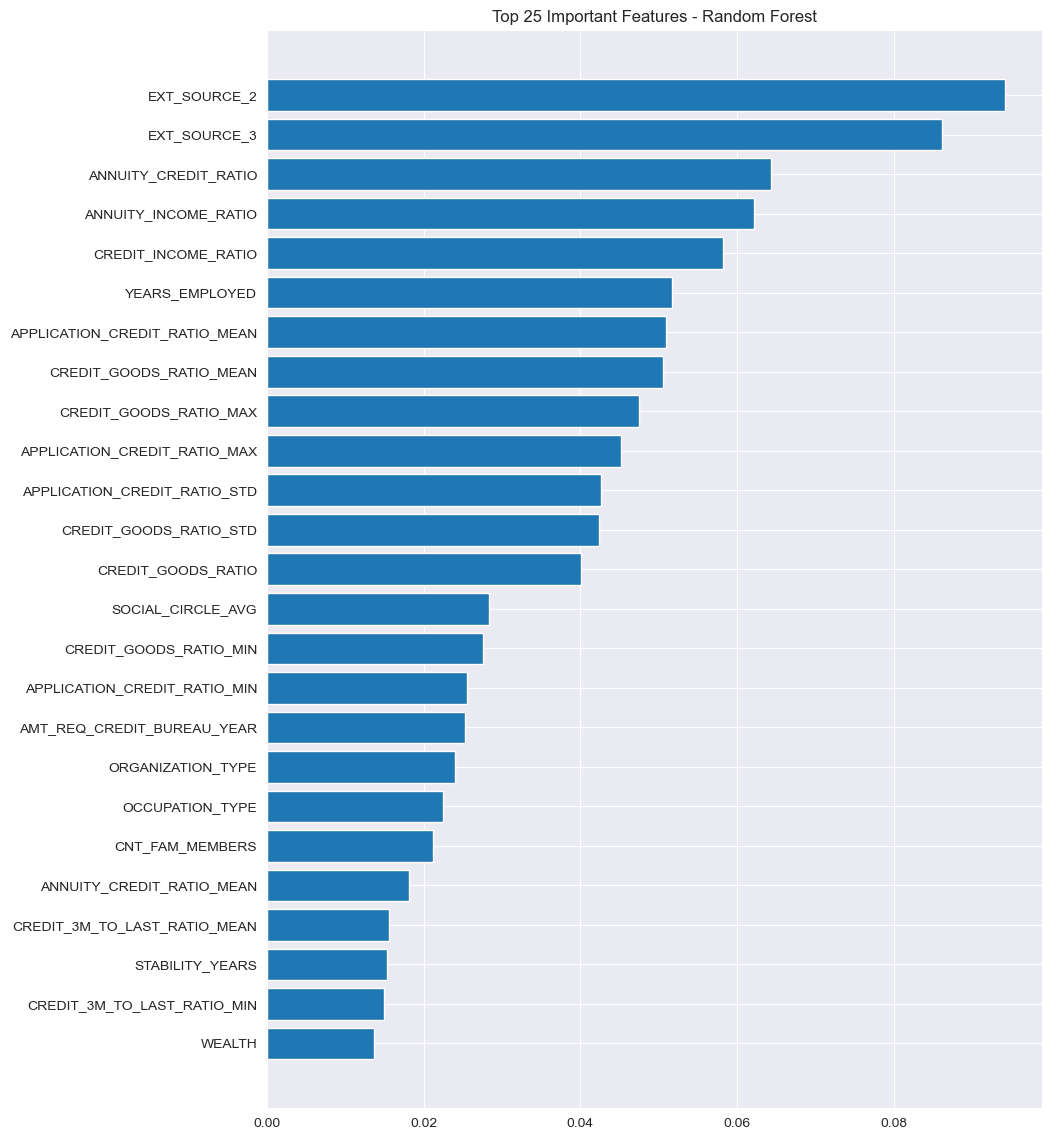

In [106]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# 1) Train Random Forest on balanced training data
# =========================================================

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

# =========================================================
# 2) Extract feature importance
# =========================================================

importances = rf.feature_importances_
feature_names = X_train.columns

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("\nTop 40 most important features:\n")
print(feat_imp.head(40))

# =========================================================
# 3) Plot Top 25 Features (optional)
# =========================================================

plt.figure(figsize=(10, 14))
plt.barh(feat_imp.head(25)["feature"], feat_imp.head(25)["importance"])
plt.gca().invert_yaxis()
plt.title("Top 25 Important Features - Random Forest")
plt.show()


In [107]:
import numpy as np
import lightgbm as lgb
from sklearn.metrics import f1_score, roc_auc_score, classification_report

# ===============================
# FOCAL PROBABILITY TRANSFORM
# ===============================
def focal_sigmoid(p, gamma=2.0):
    return p ** gamma   # simulate focal focusing

# ===============================
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.006,
    'num_leaves': 31,
    'max_depth': 7,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 200,
    'min_split_gain': 0.01,
    'reg_alpha': 5.0,
    'reg_lambda': 10.0,
    'class_weight': 'balanced',
    'subsample_for_bin': 200000,
}



model = lgb.LGBMClassifier(
    **params,
    n_estimators=3000
)

# ===============================
# FIT
# ===============================
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)


# ===============================
# PREDICT WITH FOCAL
# ===============================
raw_pred = model.predict_proba(X_test)[:, 1]
focal_pred = focal_sigmoid(raw_pred)

best_f1, best_thr = 0, 0
for thr in np.linspace(0.1, 0.6, 50):
    pred = (focal_pred >= thr).astype(int)
    f1 = f1_score(y_test, pred)
    if f1 > best_f1:
        best_f1, best_thr = f1, thr

print(f"\nBest threshold: {best_thr:.4f}")
print(f"Best F1: {best_f1:.4f}")

final_pred = (focal_pred >= best_thr).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, final_pred))

print("AUC:", roc_auc_score(y_test, focal_pred))

# ===============================
raw_pred_train = model.predict_proba(X_train)[:, 1]
focal_pred_train = focal_sigmoid(raw_pred_train)

train_pred = (focal_pred_train >= best_thr).astype(int)

print("\n=========== TRAIN REPORT ===========")
print(classification_report(y_train, train_pred))
print("Train AUC:", roc_auc_score(y_train, focal_pred_train))

[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 18602, number of negative: 211807
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4709
[LightGBM] [Info] Number of da

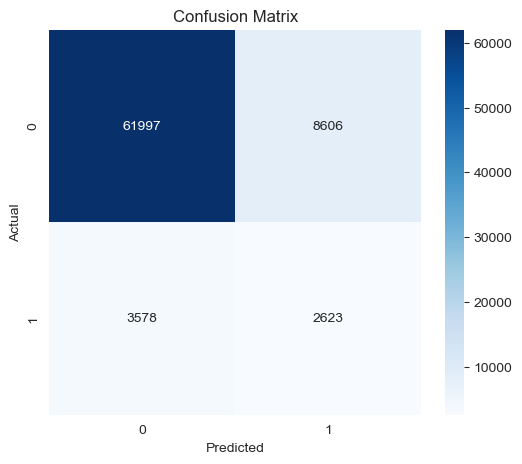

In [108]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# حساب الـ confusion matrix
cm = confusion_matrix(y_test, final_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [109]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
import lightgbm as lgb


def focal_sigmoid(p, gamma=3.0):
    return p ** gamma


params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.006,
    'num_leaves': 31,
    'max_depth': 7,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 200,
    'min_split_gain': 0.01,
    'reg_alpha': 5.0,
    'reg_lambda': 10.0,
    'class_weight': 'balanced',
    'subsample_for_bin': 200000,
    'metric': 'binary_logloss'
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_auc = []
fold_f1 = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):

    print(f"\n==================== Fold {fold+1} ====================")

    X_tr, X_val = X.iloc[train_idx], X.iloc[valid_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[valid_idx]

    model = lgb.LGBMClassifier(
        **params,
        n_estimators=3000
    )

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(stopping_rounds=100)]
    )

    raw = model.predict_proba(X_val)[:, 1]
    focal = focal_sigmoid(raw)

    # find best threshold per fold
    best_f1, best_thr = 0, 0
    for thr in np.linspace(0.05, 0.5, 80):
        pred = (focal >= thr).astype(int)
        f1 = f1_score(y_val, pred)
        if f1 > best_f1:
            best_f1, best_thr = f1, thr

    fold_auc.append(roc_auc_score(y_val, focal))
    fold_f1.append(best_f1)

    print(f"Fold AUC: {fold_auc[-1]:.4f}")
    print(f"Fold F1 : {best_f1:.4f} @ thr={best_thr:.4f}")


print("\n==================== FINAL CV RESULT ====================")
print(f"Mean AUC: {np.mean(fold_auc):.4f}  |  Std: {np.std(fold_auc):.4f}")
print(f"Mean F1 : {np.mean(fold_f1):.4f}  |  Std: {np.std(fold_f1):.4f}")


==================== Fold 1 ====================
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 19842, number of negative: 225928
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [In

In [110]:
# =====================================================
# 1) IMPORTS
# =====================================================
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras import backend as K   # <-- IMPORTANT FIX
from sklearn.metrics import roc_auc_score, f1_score, classification_report


# =====================================================
# 2) FOCAL LOSS FUNCTION (Correct Version)
# =====================================================
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, dtype='float32')
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())  # numerical stability

        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)

        weight = alpha * K.pow((1 - y_pred), gamma)
        return K.mean(weight * cross_entropy)
    return loss


# =====================================================
# 3) BUILD THE MODEL
# =====================================================
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),

    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2, alpha=0.25),
    metrics=['AUC']
)


# =====================================================
# 4) TRAIN WITH EARLY STOPPING
# =====================================================
es = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=25,
    batch_size=512,
    callbacks=[es],
    verbose=1
)


# =====================================================
# 5) EVALUATE
# =====================================================
y_train_proba = model.predict(X_train).ravel()
y_test_proba = model.predict(X_test).ravel()

y_train_pred = (y_train_proba > 0.5).astype(int)
y_test_pred = (y_test_proba > 0.5).astype(int)

print("\n================ NEURAL NETWORK WITH FOCAL LOSS ================")
print("Train AUC:", roc_auc_score(y_train, y_train_proba))
print("Test AUC:", roc_auc_score(y_test, y_test_proba))
print("Train F1:", f1_score(y_train, y_train_pred))
print("Test F1:", f1_score(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

C:\Users\LOQ\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - AUC: 0.4940 - loss: 0.0022 - val_AUC: 0.5004 - val_loss: 1.9421e-06
Epoch 2/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - AUC: 0.4989 - loss: 2.0411e-05 - val_AUC: 0.5003 - val_loss: 1.8555e-07
Epoch 3/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - AUC: 0.4991 - loss: 6.8895e-06 - val_AUC: 0.5001 - val_loss: 5.2697e-08
Epoch 4/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - AUC: 0.4998 - loss: 3.8880e-06 - val_AUC: 0.5000 - val_loss: 2.0731e-08
Epoch 5/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - AUC: 0.4995 - loss: 2.5837e-06 - val_AUC: 0.5000 - val_loss: 9.6615e-09
Epoch 6/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - AUC: 0.5000 - loss: 1.2341e-06 - val_AUC: 0.5000 - val_loss: 5.0561e-09
Epoch 7/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - AUC: 0.4997 - loss: 1.0124e-06 - val_AUC: 0.5000 - val_loss: 3.0751e-09
Epoch 8/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - AUC: 0.5003 - loss: 6.2705e-07 - val_AUC: 0.5000 - val_loss

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [111]:
df.head()

,TARGET,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_YEAR,PHONE_CHANGE_STATUS,WEALTH,STABILITY_YEARS,...,CREDIT_GOODS_RATIO_MAX,CREDIT_GOODS_RATIO_MIN,CREDIT_GOODS_RATIO_STD,ANNUITY_CREDIT_RATIO_MEAN,APPLICATION_CREDIT_RATIO_MEAN,APPLICATION_CREDIT_RATIO_MAX,APPLICATION_CREDIT_RATIO_MIN,APPLICATION_CREDIT_RATIO_STD,CREDIT_3M_TO_LAST_RATIO_MEAN,CREDIT_3M_TO_LAST_RATIO_MIN
0,1,1,1.0,0,0.262949,0.139376,1.0,0,2,2,...,1.000000,1.000000,0.000000,5.167002e-02,1.000000,1.000000,1.000000,0.000000,1.000000e+00,1.000000
1,0,0,2.0,1,0.622246,0.546023,0.0,0,1,2,...,1.150980,0.989013,0.083753,1.263834e-01,0.949329,1.011109,0.868825,0.072967,1.328538e+00,1.000000
2,0,1,1.0,3,0.555912,0.729567,0.0,0,0,2,...,0.828021,0.828021,0.000000,2.664503e-01,1.207699,1.207699,1.207699,0.000000,1.000000e+00,1.000000
3,0,1,2.0,0,0.650442,0.560284,2.0,0,2,0,...,1.316797,0.000000,0.491534,4.688077e+12,0.758072,1.250017,0.000000,0.488096,7.171875e+13,0.408468
4,0,0,1.0,5,0.322738,0.562060,0.0,0,2,2,...,1.264000,0.850930,0.137998,9.065882e-02,0.969650,1.175185,0.791139,0.128282,9.694093e-01,0.816456


# model

In [112]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, classification_report

# SELECT ONLY THE TOP 17 FEATURES
# =========================================================
top_17_features = [
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "ANNUITY_CREDIT_RATIO",
    "ANNUITY_INCOME_RATIO",
    "CREDIT_INCOME_RATIO",
    "YEARS_EMPLOYED",
    "APPLICATION_CREDIT_RATIO_MEAN",
    "APPLICATION_CREDIT_RATIO_MAX",
    "APPLICATION_CREDIT_RATIO_STD",
    "CREDIT_GOODS_RATIO_MEAN",
    "CREDIT_GOODS_RATIO_MAX",
    "CREDIT_GOODS_RATIO_STD",
    "APPLICATION_CREDIT_RATIO_MIN",
    "CREDIT_GOODS_RATIO_MIN",
    "SOCIAL_CIRCLE_AVG",
    "AMT_REQ_CREDIT_BUREAU_YEAR",
    "CREDIT_3M_TO_LAST_RATIO_MEAN"
]

# DROP EVERYTHING EXCEPT 17 FEATURES + TARGET
# =========================================================
df = df[top_17_features + ["TARGET"]]

# SPLIT TRAIN / TEST
# =========================================================
X = df[top_17_features]
y = df["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# SHOW TARGET DISTRIBUTION
print("\n=== ORIGINAL TARGET DISTRIBUTION ===")
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

# FOCAL TRANSFORMATION
def focal_sigmoid(p, gamma=2.0):
    return p ** gamma

# LIGHTGBM PARAMETERS
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.006,
    'num_leaves': 31,
    'max_depth': 7,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 200,
    'min_split_gain': 0.01,
    'reg_alpha': 5.0,
    'reg_lambda': 10.0,
    'class_weight': 'balanced',
}

model = lgb.LGBMClassifier(
    **params,
    n_estimators=3000
)

# TRAIN MODEL
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

# PREDICT RAW PROBABILITY
raw_pred = model.predict_proba(X_test)[:, 1]

print("\n=== VALUE COUNTS BEFORE FOCAL (RAW PROB>=0.5) ===")
print(pd.Series((raw_pred >= 0.5).astype(int)).value_counts(normalize=True))

# APPLY FOCAL TRANSFORM
focal_pred = focal_sigmoid(raw_pred)

print("\n=== VALUE COUNTS AFTER FOCAL (>=0.5) ===")
print(pd.Series((focal_pred >= 0.5).astype(int)).value_counts(normalize=True))

# FIND BEST THRESHOLD
best_f1, best_thr = 0, 0
for thr in np.linspace(0.1, 0.6, 50):
    pred = (focal_pred >= thr).astype(int)
    f1 = f1_score(y_test, pred)
    if f1 > best_f1:
        best_f1, best_thr = f1, thr

print(f"\nBest threshold: {best_thr:.4f}")
print(f"Best F1: {best_f1:.4f}")

# FINAL PREDICTION
final_pred = (focal_pred >= best_thr).astype(int)

print("\n=== VALUE COUNTS AFTER THRESHOLD OPTIM ===")
print(pd.Series(final_pred).value_counts(normalize=True))

# REPORTS
print("\nClassification Report:")
print(classification_report(y_test, final_pred))

print("AUC:", roc_auc_score(y_test, focal_pred))

# TRAIN EVAL
raw_pred_train = model.predict_proba(X_train)[:, 1]
focal_pred_train = focal_sigmoid(raw_pred_train)
train_pred = (focal_pred_train >= best_thr).astype(int)

print("\n=========== TRAIN REPORT ===========")
print(classification_report(y_train, train_pred))
print("Train AUC:", roc_auc_score(y_train, focal_pred_train))


Train shape: (230409, 17)
Test shape: (76804, 17)

=== ORIGINAL TARGET DISTRIBUTION ===
TARGET
0    0.919265
1    0.080735
Name: proportion, dtype: float64
TARGET
0    0.919262
1    0.080738
Name: proportion, dtype: float64
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 18602, number of negative: 211807
[L

In [113]:
# import pickle
#
# with open("models/credit_model.pkl", "wb") as f:
#     pickle.dump(model, f)
# print("\nModel saved successfully as credit_model.pkl")

FileNotFoundError: [Errno 2] No such file or directory: 'models/credit_model.pkl'

In [114]:
for col in df.columns:
  print(col.upper())
  print(df[col].unique())
  print("\n--------------------------------------")

EXT_SOURCE_2
[0.26294859 0.62224578 0.55591208 ... 0.13118876 0.26448565 0.2678342 ]

--------------------------------------
EXT_SOURCE_3
[1.39375780e-01 5.46023197e-01 7.29566691e-01 5.60284328e-01
 5.62060483e-01 6.21226338e-01 4.92060094e-01 5.40654450e-01
 7.51723715e-01 5.13693766e-01 3.63945239e-01 6.52896552e-01
 1.76652579e-01 7.70087070e-01 5.33481630e-01 6.78567689e-01
 6.21030378e-02 4.43615308e-01 5.56727426e-01 4.77649155e-01
 5.83237926e-01 5.42445144e-01 3.58951229e-01 6.69056695e-01
 5.65607981e-01 4.61482391e-01 1.90705948e-01 6.59405532e-01
 5.24496446e-01 4.68659655e-01 4.10102573e-01 4.88455184e-01
 7.98137231e-01 4.11848556e-01 7.54406173e-01 7.22392890e-01
 6.05836265e-01 3.20163367e-01 5.26294940e-01 3.99675616e-01
 6.84827659e-01 4.45396242e-01 3.03146374e-01 4.75849909e-01
 7.28141299e-01 4.66864006e-01 4.79448981e-01 3.09275356e-01
 7.99296783e-01 7.01695774e-01 7.38019620e-01 7.01088438e-02
 1.69428727e-01 7.07699345e-01 3.39287700e-01 6.97146908e-01
 4.34733

In [29]:
print(X_train.columns.tolist())


['EXT_SOURCE_2', 'EXT_SOURCE_3', 'ANNUITY_CREDIT_RATIO', 'ANNUITY_INCOME_RATIO', 'CREDIT_INCOME_RATIO', 'YEARS_EMPLOYED', 'APPLICATION_CREDIT_RATIO_MEAN', 'APPLICATION_CREDIT_RATIO_MAX', 'APPLICATION_CREDIT_RATIO_STD', 'CREDIT_GOODS_RATIO_MEAN', 'CREDIT_GOODS_RATIO_MAX', 'CREDIT_GOODS_RATIO_STD', 'APPLICATION_CREDIT_RATIO_MIN', 'CREDIT_GOODS_RATIO_MIN', 'SOCIAL_CIRCLE_AVG', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CREDIT_3M_TO_LAST_RATIO_MEAN']


In [30]:
df['TARGET'].value_counts(normalize=True)

TARGET
0    0.919264
1    0.080736
Name: proportion, dtype: float64

In [115]:
df.drop(columns=["TARGET"]).head(30).to_csv("sample_head.csv", index=False)


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307213 entries, 0 to 307212
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   EXT_SOURCE_2                   307213 non-null  float64
 1   EXT_SOURCE_3                   307213 non-null  float64
 2   ANNUITY_CREDIT_RATIO           307213 non-null  float64
 3   ANNUITY_INCOME_RATIO           307213 non-null  float64
 4   CREDIT_INCOME_RATIO            307213 non-null  float64
 5   YEARS_EMPLOYED                 307213 non-null  float64
 6   APPLICATION_CREDIT_RATIO_MEAN  307213 non-null  float64
 7   APPLICATION_CREDIT_RATIO_MAX   307213 non-null  float64
 8   APPLICATION_CREDIT_RATIO_STD   307213 non-null  float64
 9   CREDIT_GOODS_RATIO_MEAN        307213 non-null  float64
 10  CREDIT_GOODS_RATIO_MAX         307213 non-null  float64
 11  CREDIT_GOODS_RATIO_STD         307213 non-null  float64
 12  APPLICATION_CREDIT_RATIO_MIN  

# unsupervised

In [117]:
label_col = "TARGET"
X = df.drop(columns=[label_col]).values
y = df[label_col].astype(int).values

from sklearn.model_selection import train_test_split

# 80% Train — 20% Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (245770, 17) (245770,)
Test shape: (61443, 17) (61443,)


In [118]:
from sklearn.ensemble import IsolationForest
from sklearn import metrics

contamination_est = max(0.001, y.mean())
print("Estimated contamination:", contamination_est)

iso = IsolationForest(
    n_estimators=100,
    contamination=contamination_est,
    random_state=42,
    n_jobs=-1
)

iso.fit(X_train)
y_pred_test = (iso.predict(X_test) == -1).astype(int)

print(metrics.classification_report(y_test, y_pred_test))


Estimated contamination: 0.08073551574965904
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     56482
           1       0.08      0.08      0.08      4961

    accuracy                           0.85     61443
   macro avg       0.50      0.50      0.50     61443
weighted avg       0.85      0.85      0.85     61443



In [119]:
import optuna
from sklearn import metrics

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int("n_estimators", 50, 400),
        'max_samples': trial.suggest_float("max_samples", 0.5, 1.0),
        'max_features': trial.suggest_float("max_features", 0.5, 1.0),
        'bootstrap': trial.suggest_categorical("bootstrap", [True, False]),
        'contamination': trial.suggest_float("contamination", contamination_est*0.5, contamination_est*1.5),
    }

    model = IsolationForest(
        **params,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train)

    preds = (model.predict(X_test) == -1).astype(int)
    f1 = metrics.f1_score(y_test, preds, zero_division=0)

    return f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

print("Best Params →", study.best_params)
print("Best F1 →", study.best_value)


[I 2025-11-30 01:31:41,290] A new study created in memory with name: no-name-6ba6a69c-cf9e-45eb-9e30-652dcb3d8964
[I 2025-11-30 01:32:17,597] Trial 0 finished with value: 0.09569215051932572 and parameters: {'n_estimators': 366, 'max_samples': 0.8877594522041466, 'max_features': 0.7676087056172944, 'bootstrap': True, 'contamination': 0.10793785234692661}. Best is trial 0 with value: 0.09569215051932572.
[I 2025-11-30 01:32:23,367] Trial 1 finished with value: 0.07244270542202348 and parameters: {'n_estimators': 54, 'max_samples': 0.722905664277729, 'max_features': 0.925238782460525, 'bootstrap': True, 'contamination': 0.062445493576927226}. Best is trial 0 with value: 0.09569215051932572.
[I 2025-11-30 01:33:01,265] Trial 2 finished with value: 0.0948376129551758 and parameters: {'n_estimators': 370, 'max_samples': 0.7271497751415188, 'max_features': 0.6664715113275819, 'bootstrap': True, 'contamination': 0.0985045419101234}. Best is trial 0 with value: 0.09569215051932572.
[I 2025-11-

Best Params → {'n_estimators': 68, 'max_samples': 0.9617285339854638, 'max_features': 0.5027160844778098, 'bootstrap': True, 'contamination': 0.11921150102475639}
Best F1 → 0.10754234579737935


In [120]:
best_params = study.best_params

best_model = IsolationForest(
    **best_params,
    random_state=42,
    n_jobs=-1
)

# Train على كل الـ Train data فقط
best_model.fit(X_train)

y_pred_test_best = (best_model.predict(X_test) == -1).astype(int)

print(metrics.classification_report(y_test, y_pred_test_best))

iso_score_train = -best_model.score_samples(X_train)
iso_score_test = -best_model.score_samples(X_test)

X_train_with_iso = np.column_stack([X_train, iso_score_train])
X_test_with_iso = np.column_stack([X_test, iso_score_test])

y_pred_test_best = (best_model.predict(X_test) == -1).astype(int)

print("IsolationForest classification report (before using as feature):")
print(metrics.classification_report(y_test, y_pred_test_best))

print("New shapes after adding iso_score:")
print(X_train_with_iso.shape, X_test_with_iso.shape)


              precision    recall  f1-score   support

           0       0.92      0.88      0.90     56482
           1       0.09      0.14      0.11      4961

    accuracy                           0.82     61443
   macro avg       0.50      0.51      0.50     61443
weighted avg       0.85      0.82      0.83     61443

IsolationForest classification report (before using as feature):
              precision    recall  f1-score   support

           0       0.92      0.88      0.90     56482
           1       0.09      0.14      0.11      4961

    accuracy                           0.82     61443
   macro avg       0.50      0.51      0.50     61443
weighted avg       0.85      0.82      0.83     61443

New shapes after adding iso_score:
(245770, 18) (61443, 18)


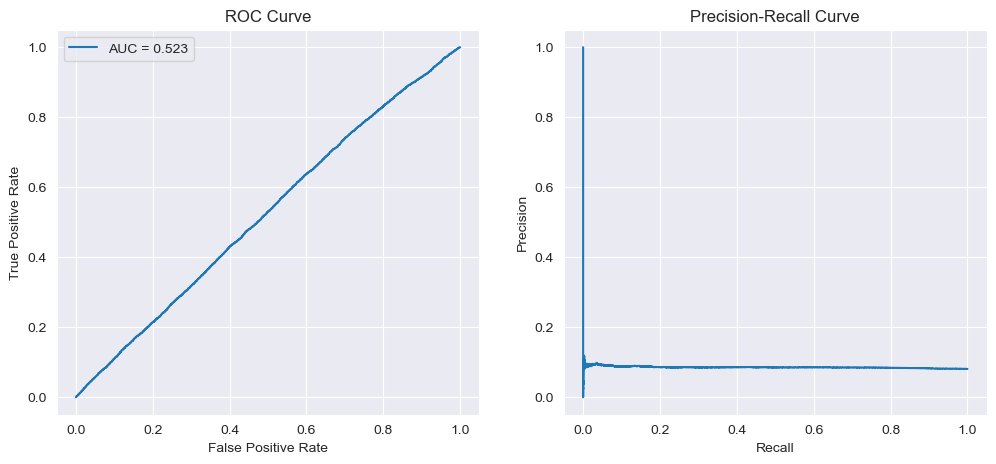

In [121]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Negative score_samples → higher = more anomaly
scores = -best_model.score_samples(X_test)

# ROC
fpr, tpr, _ = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)

# PR
precision, recall, _ = precision_recall_curve(y_test, scores)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")

plt.show()


In [122]:
thresholds = np.linspace(min(scores), max(scores), 200)
best_f1 = -1
best_t = None

for t in thresholds:
    preds = (scores >= t).astype(int)   # 1 anomaly
    f1 = metrics.f1_score(y_test, preds, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print("Best Threshold =", best_t)
print("Best F1 after threshold tuning =", best_f1)


Best Threshold = 0.40439368915915425
Best F1 after threshold tuning = 0.15243203406485425


In [123]:
y_pred_threshold = (scores >= best_t).astype(int)

print(metrics.classification_report(y_test, y_pred_threshold))


              precision    recall  f1-score   support

           0       0.93      0.29      0.44     56482
           1       0.08      0.75      0.15      4961

    accuracy                           0.33     61443
   macro avg       0.51      0.52      0.30     61443
weighted avg       0.86      0.33      0.42     61443

